# Source finding demo

## 1. Initialisation

### imports:

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from astropy.io import fits# BLOCK-COMMENT

from numba import njit
from photutils import segmentation as segm
from scipy.spatial import ConvexHull

import fabada as f

## 2. Read data

### select one dataset:

In [2]:
dataset = 2

In [3]:
plots = True

In [4]:
#plots = False

1D spectra

2D images:

In [5]:
if dataset == 1:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data[69]*1.  # to make sure it's converted to float
    #data = hdu[0].data[:, 270, :]*1.
    #data = hdu[0].data[:, 170, :]*1.
    #data = hdu[0].data[99]*1.

In [6]:
if dataset == 2:
    hdu = fits.open('data/CIG_335.fits')
    data = hdu[0].data[3000:4000, 1500:2500] * 1.  # to make sure it's converted to float

3D datacubes:

In [7]:
if dataset == 3:
    hdu = fits.open('data/hcg44_cube_R.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


In [8]:
if dataset == 4:
    hdu = fits.open('data/sofiawsrtcube.fits')
    data = hdu[0].data *1.  # to make sure it's converted to float


### visual inspection:

In [9]:
data_dimensionality = len(data.shape)

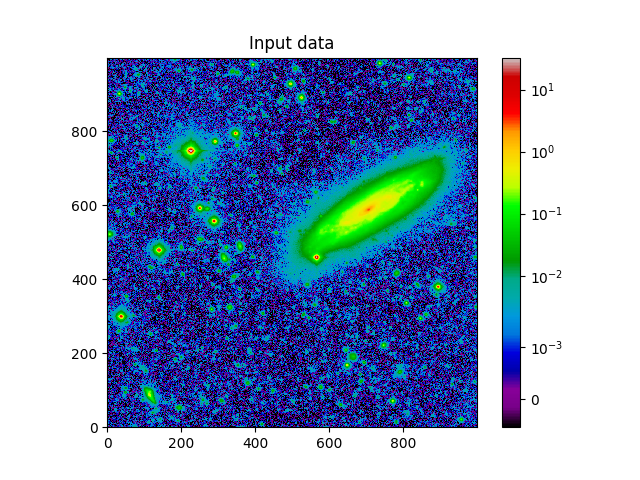

In [10]:
if plots and data_dimensionality == 2:
    plt.close('data')
    fig = plt.figure('data')
    ax = fig.subplots()

    dmin, dmed, dmax = np.nanpercentile(data, [16, 50, 100])
    im = ax.imshow(data,
                   interpolation='nearest', origin='lower', cmap='nipy_spectral',
                   norm=colors.SymLogNorm(vmin=dmin, linthresh=dmed-dmin, vmax=dmax),
                  )
    ax.set_title('Input data')
    cb = fig.colorbar(im, ax=ax)
    plt.show()

In [11]:
if plots and data_dimensionality == 3:
    plt.close('data')
    fig = plt.figure('data', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
    fig.set_tight_layout(True)
    
    lo = np.nanpercentile(data, 60)
    hi = np.nanpercentile(data, 99)

    im = ax[0, 0].imshow(np.sqrt(np.nanmean(data**2, axis=0)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[0, 0].set_title('Input data (rms value along specral axis)')

    im = ax[0, 1].imshow(np.sqrt(np.nanmean(data**2, axis=2)).T,
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[0, 1].set_aspect('auto')
    
    im = ax[1, 0].imshow(np.sqrt(np.nanmean(data**2, axis=1)),
                   interpolation='nearest', origin='lower', cmap='terrain',
                   vmin=lo, vmax=hi,
                  )
    ax[1, 0].set_aspect('auto')
    
    cb = fig.colorbar(im, ax=ax[1, 1])
    ax[1, 1].set_visible(False)
    plt.show()

## 3. Find mode

### number density and cumulative fraction:

In [12]:
flat_data = data.ravel()
argsort_data_ravel = np.argsort(flat_data, axis=None)
number_fraction = (np.arange(data.size)+0.5)/data.size

I had to downsaple, both for smoothing as well as to avoid numerical problems (CPU time, and even crashes due to the memory required by the plots) 

In [13]:
d50 = flat_data[argsort_data_ravel[data.size//2]]
print(f'Data median: {d50:.3g}')
bg_std = np.sqrt(np.mean((flat_data[argsort_data_ravel[:data.size//2]] - d50)**2))
print(f'First guess of background standard deviation: {bg_std:.3g}')

d_left = flat_data[argsort_data_ravel[1]]
d_right = d50 + 2*(d50-d_left)
n_steps = int(100*(d_right-d_left)/bg_std)
data_sample = np.linspace(d_left, d_right, n_steps)
print(f'Data subsampled to {n_steps} linear steps between {d_left:.3g} and {d_right:.3g}')

Data median: 0.000786
First guess of background standard deviation: 0.0013
Data subsampled to 1311 linear steps between -0.0049 and 0.0122


Smooth density field (boxcar with $h=\sigma_{bg}$, i.e. between $x \pm \frac{\sigma_{bg}}{2}$):

In [14]:
h_smooth = bg_std
m_left = np.interp(data_sample-h_smooth/2, flat_data[argsort_data_ravel], number_fraction)
m_right = np.interp(data_sample+h_smooth/2, flat_data[argsort_data_ravel], number_fraction)
data_sample_rho_smooth = (m_right-m_left) / h_smooth

### density mode:

Naive method:

In [15]:
data_mode = data_sample[np.argmax(data_sample_rho_smooth)]
print(f'Naive mode:{data_mode:.3g}')

Naive mode:0.000439


More stable:

In [16]:
weight = data_sample_rho_smooth**10
data_mode = np.sum(data_sample*weight) / np.sum(weight)
print(f'More stable:{data_mode:.3g}')

More stable:0.000467


In [17]:
index_mode = np.searchsorted(flat_data[argsort_data_ravel], data_mode)
bg_std = np.sqrt(np.mean((flat_data[argsort_data_ravel[:index_mode]]- data_mode)**2))
print(f'background std={bg_std:.3g}')

background std=0.00116


## 4. Signal / background classification

### compute probability:

Asumming that the background intensity is symmetric around $I_0$, which is well traced by the mode,
$$ p_{bg}(I > I_0) = \frac{p(2I_0-I)}{p(I)} ~~;~~ p_{src} = 1 - p_{bg}$$

In [18]:
rho_sym = np.interp(2*data_mode-data_sample, data_sample, data_sample_rho_smooth, left=0)
probability_bg = np.clip(rho_sym/data_sample_rho_smooth, 0, 1)
src_probability_map = 1 - np.interp(data, data_sample, probability_bg)

### estimate threshold:

a) The number of background pixels is the same above and below mode:

In [19]:
N_mode = np.count_nonzero(data < data_mode)
N_src = np.sum(src_probability_map)
N_background = data.size-N_src
print(f'{N_mode} ({100*N_mode/data.size:.1f}%) pixels below mode')
print(f'{N_background} ({100*N_background/data.size:.1f}%) background pixels; N_background/N_mode={N_background/N_mode}')
print(f'{data.size-N_background} ({100-100*N_background/data.size:.1f}%) source pixels; N_pixels-2N_mode={data.size-2*N_mode}')

number_threshold = flat_data[argsort_data_ravel[int(N_background)]]
print(f'Number-based threshold={number_threshold:.3g}, ({(number_threshold-data_mode)/bg_std:.3g} sigmas)')

412351 (41.2%) pixels below mode
826566.3166398421 (82.7%) background pixels; N_background/N_mode=2.0045211885986505
173433.68336015788 (17.3%) source pixels; N_pixels-2N_mode=175298
Number-based threshold=0.00282, (2.02 sigmas)


b) The background flux is the same:

In [20]:
total_flux_below_mode = np.sum(data_mode-flat_data[argsort_data_ravel[:index_mode]])
flux_above_mode = np.cumsum(flat_data[argsort_data_ravel[index_mode:]]-data_mode)
flux_threshold = np.interp(total_flux_below_mode, flux_above_mode, flat_data[argsort_data_ravel[index_mode:]])
print(f'Total flux: {total_flux_below_mode:.3g} below mode, {flux_above_mode[-1]:.3g} above')
print(f'Flux-based threshold={flux_threshold:.3g} ({(flux_threshold-data_mode)/bg_std:.3g} sigmas)')

Total flux: 383 below mode, 1.31e+04 above
Flux-based threshold=0.00289 (2.08 sigmas)


c) Below the mode, $p_{src}$ and $p_{bg}$ should be zero and one, respectively. The maximum difference found sets the (un)reliable regime:

In [21]:
reliable_bg_probability = np.min(probability_bg[data_sample < data_mode])
reliable_src_probability = 1 - reliable_bg_probability
probability_threshold = np.min(data_sample[probability_bg < reliable_bg_probability])
print(f'Reliable probabilities: p_src > {reliable_src_probability:.3g}; p_bg < {reliable_bg_probability:.3g}')
print(f'Probability-based threshold={probability_threshold:.3g} ({(probability_threshold-data_mode)/bg_std:.3g} sigmas)')

Reliable probabilities: p_src > 0.0054; p_bg < 0.995
Probability-based threshold=0.00127 (0.694 sigmas)


Now, take the minimum of three:

In [22]:
threshold_guess = min([number_threshold, flux_threshold, probability_threshold])
delta_th = (threshold_guess - data_mode) / bg_std

In [23]:
colour_scale = colors.SymLogNorm(vmin=d_left, linthresh=threshold_guess, vmax=np.nanmax(data))

### summary plot:

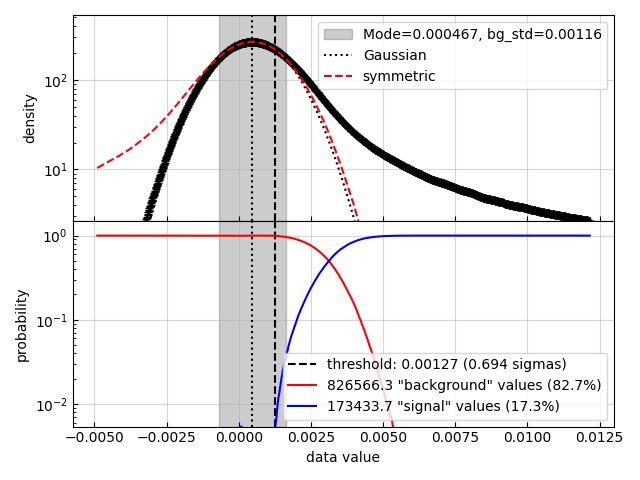

In [24]:
if plots:
    plt.close('density')
    fig = plt.figure('density')
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        axis.axvline(data_mode, c='k', ls=':')
        shade = axis.fill_between(data_sample, 0, 1, where=np.abs(data_sample-data_mode) <= bg_std,
                          color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                          label=f'Mode={data_mode:.3g}, bg_std={bg_std:.3g}')
        th_line = axis.axvline(threshold_guess, c='k', ls='--')
    fig.set_tight_layout(True)

    ax[0, 0].set_ylabel('density')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(data_sample_rho_smooth[data_sample > data_mode]), 2*np.max(data_sample_rho_smooth))
    ax[0, 0].plot(data_sample, data_sample_rho_smooth, 'k+')
    ax[0, 0].plot(data_sample,
                  np.exp(-.5*((data_sample-data_mode)/bg_std)**2) * N_background/data.size/np.sqrt(2*np.pi)/bg_std,
                  'k:', label='Gaussian')
    ax[0, 0].plot(data_sample, rho_sym, 'r--', label='symmetric')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('probability')
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_ylim(reliable_src_probability, 1.5)
    ax[1, 0].plot(data_sample, probability_bg, 'r-',
                  label=f'{N_background:.1f} "background" values ({100*N_background/data.size:.1f}%)')
    ax[1, 0].plot(data_sample, 1-probability_bg, 'b-',
                  label=f'{data.size-N_background:.1f} "signal" values ({100-100*N_background/data.size:.1f}%)')
    shade.set_label('')
    th_line.set_label(f'threshold: {threshold_guess:.3g} ({delta_th:.3g} sigmas)')
    ax[1, 0].legend()

    ax[-1, 0].set_xlabel('data value')


## 5. Noise reduction (FABADA)

In [25]:
smoothed_data = f.fabada(data, bg_std**2, verbose=True)
#smoothed_data = data

FABADA 2-D initialize
Iteration =     7 ; <E> = 246.81 ; Chi^2 = 2.0313e+09/1.000e+06 
Finish at 7 iterations  and with an execute time of 0.45 seconds.


In [26]:
flat_smoothed_data = smoothed_data.ravel()
argsort_smoothed_data_ravel = np.argsort(flat_smoothed_data, axis=None)

I had to downsaple, both for smoothing as well as to avoid numerical problems (CPU time, and even crashes due to the memory required by the plots) 

In [27]:
d50 = flat_smoothed_data[argsort_smoothed_data_ravel[data.size//2]]
print(f'Data median: {d50:.3g}')
smoothed_bg_std = np.sqrt(np.mean((flat_smoothed_data[argsort_smoothed_data_ravel[:data.size//2]]-d50)**2))
print(f'First guess of background standard deviation: {smoothed_bg_std:.3g}')

d_left = flat_smoothed_data[argsort_smoothed_data_ravel[1]]
d_right = d50 + 2*(d50-d_left)
n_steps = int(100*(d_right-d_left)/bg_std)
smoothed_data_sample = np.linspace(d_left, d_right, n_steps)
print(f'Smoothed data subsampled to {n_steps} linear steps between {d_left:.3g} and {d_right:.3g}')

Data median: 0.000604
First guess of background standard deviation: 0.000633
Smoothed data subsampled to 1118 linear steps between -0.00373 and 0.00926


Smooth density field (boxcar with $h=\sigma_{bg}$, i.e. between $x \pm \frac{\sigma_{bg}}{2}$):

In [28]:
h_smooth = smoothed_bg_std
m_left = np.interp(smoothed_data_sample-h_smooth/2, flat_smoothed_data[argsort_smoothed_data_ravel], number_fraction)
m_right = np.interp(smoothed_data_sample+h_smooth/2, flat_smoothed_data[argsort_smoothed_data_ravel], number_fraction)
smoothed_data_sample_rho_smooth = (m_right-m_left) / h_smooth

### density mode:

Naive method:

In [29]:
smoothed_data_mode = smoothed_data_sample[np.argmax(smoothed_data_sample_rho_smooth)]
print(f'Naive mode:{smoothed_data_mode:.3g}')

Naive mode:0.000321


More stable:

In [30]:
weight = smoothed_data_sample_rho_smooth**10
smoothed_data_mode = np.sum(smoothed_data_sample*weight) / np.sum(weight)
print(f'More stable:{smoothed_data_mode:.3g}')

More stable:0.000343


In [31]:
index_mode = np.searchsorted(flat_smoothed_data[argsort_smoothed_data_ravel], smoothed_data_mode)
smoothed_bg_std = np.sqrt(np.mean((flat_smoothed_data[argsort_smoothed_data_ravel[:index_mode]]- smoothed_data_mode)**2))
normalised_smoothed_data = (smoothed_data-smoothed_data_mode)/smoothed_bg_std
print(f'background std={smoothed_bg_std:.3g}')

background std=0.000513


## 6. New signal / background classification

### compute probability:

Asumming that the background intensity is symmetric around $I_0$, which is well traced by the mode,
$$ p_{bg}(I > I_0) = \frac{p(2I_0-I)}{p(I)} ~~;~~ p_{src} = 1 - p_{bg}$$

In [32]:
rho_sym = np.interp(2*smoothed_data_mode-smoothed_data_sample, smoothed_data_sample, smoothed_data_sample_rho_smooth, left=0)
smoothed_probability_bg = np.clip(rho_sym/smoothed_data_sample_rho_smooth, 0, 1)
smoothed_src_probability_map = 1 - np.interp(smoothed_data, smoothed_data_sample, smoothed_probability_bg)

### estimate threshold:

a) The number of background pixels is the same above and below mode:

In [33]:
N_mode = np.count_nonzero(smoothed_data < smoothed_data_mode)
N_src = np.sum(smoothed_src_probability_map)
N_background = smoothed_data.size-N_src
print(f'{N_mode} ({100*N_mode/data.size:.1f}%) pixels below mode')
print(f'{N_background} ({100*N_background/data.size:.1f}%) background pixels; N_background/N_mode={N_background/N_mode}')
print(f'{data.size-N_background} ({100-100*N_background/data.size:.1f}%) source pixels; N_pixels-2N_mode={data.size-2*N_mode}')

number_threshold = flat_data[argsort_smoothed_data_ravel[int(N_background)]]
print(f'Number-based threshold={number_threshold:.3g}, ({(number_threshold-smoothed_data_mode)/bg_std:.3g} sigmas)')

362119 (36.2%) pixels below mode
725756.3759834175 (72.6%) background pixels; N_background/N_mode=2.004193030422092
274243.6240165825 (27.4%) source pixels; N_pixels-2N_mode=275762
Number-based threshold=0.000503, (0.138 sigmas)


b) The background flux is the same:

In [34]:
total_flux_below_mode = np.sum(smoothed_data_mode-flat_smoothed_data[argsort_smoothed_data_ravel[:index_mode]])
flux_above_mode = np.cumsum(flat_smoothed_data[argsort_smoothed_data_ravel[index_mode:]]-smoothed_data_mode)
flux_threshold = np.interp(total_flux_below_mode, flux_above_mode, flat_smoothed_data[argsort_smoothed_data_ravel[index_mode:]])
print(f'Total flux: {total_flux_below_mode:.3g} below mode, {flux_above_mode[-1]:.3g} above')
print(f'Flux-based threshold={flux_threshold:.3g} ({(flux_threshold-smoothed_data_mode)/bg_std:.3g} sigmas)')

Total flux: 148 below mode, 1.31e+04 above
Flux-based threshold=0.00134 (0.858 sigmas)


c) Below the mode, $p_{src}$ and $p_{bg}$ should be zero and one, respectively. The maximum difference found sets the (un)reliable regime:

In [35]:
reliable_bg_probability = np.min(smoothed_probability_bg[smoothed_data_sample < smoothed_data_mode])
reliable_src_probability = 1 - reliable_bg_probability
probability_threshold = np.min(smoothed_data_sample[smoothed_probability_bg < reliable_bg_probability])
print(f'Reliable probabilities: p_src > {reliable_src_probability:.3g}; p_bg < {reliable_bg_probability:.3g}')
print(f'Probability-based threshold={probability_threshold:.3g} ({(probability_threshold-smoothed_data_mode)/bg_std:.3g} sigmas)')

Reliable probabilities: p_src > 0.00942; p_bg < 0.991
Probability-based threshold=0.000716 (0.321 sigmas)


Now, take the minimum of three:

In [36]:
#smoothed_threshold_guess = probability_threshold
smoothed_threshold_guess = min([number_threshold, flux_threshold, probability_threshold])

### summary plot:

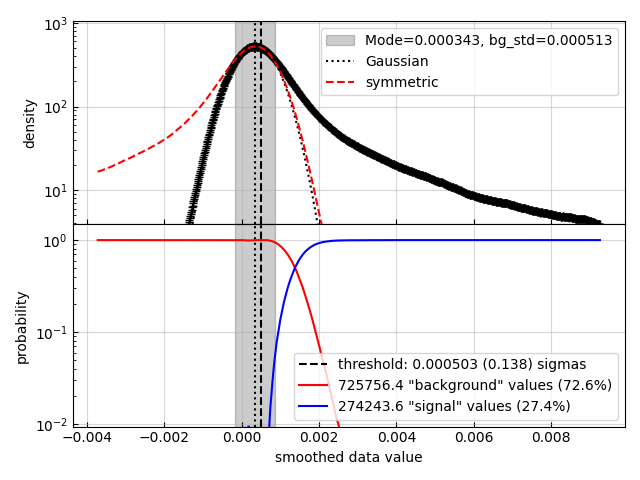

In [37]:
if plots:
    plt.close('smoothed_density')
    fig = plt.figure('smoothed_density')
    ax = fig.subplots(nrows=2, ncols=1, squeeze=False,
                      sharex='col', sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        axis.set_aspect('auto')
        axis.axvline(smoothed_data_mode, c='k', ls=':')
        shade = axis.fill_between(smoothed_data_sample, 0, 1, where=np.abs(smoothed_data_sample-smoothed_data_mode) <= smoothed_bg_std,
                          color='k', alpha=0.2, transform=axis.get_xaxis_transform(),
                          label=f'Mode={smoothed_data_mode:.3g}, bg_std={smoothed_bg_std:.3g}')
        th_line = axis.axvline(smoothed_threshold_guess, c='k', ls='--')
    fig.set_tight_layout(True)

    ax[0, 0].set_ylabel('density')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(np.min(smoothed_data_sample_rho_smooth[smoothed_data_sample > smoothed_data_mode]), 2*np.max(smoothed_data_sample_rho_smooth))
    ax[0, 0].plot(smoothed_data_sample, smoothed_data_sample_rho_smooth, 'k+')
    ax[0, 0].plot(smoothed_data_sample,
                  np.exp(-.5*((smoothed_data_sample-smoothed_data_mode)/smoothed_bg_std)**2) * N_background/data.size/np.sqrt(2*np.pi)/smoothed_bg_std,
                  'k:', label='Gaussian')
    ax[0, 0].plot(smoothed_data_sample, rho_sym, 'r--', label='symmetric')
    ax[0, 0].legend()

    ax[1, 0].set_ylabel('probability')
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_ylim(reliable_src_probability, 1.5)
    ax[1, 0].plot(smoothed_data_sample, smoothed_probability_bg, 'r-',
                  label=f'{N_background:.1f} "background" values ({100*N_background/data.size:.1f}%)')
    ax[1, 0].plot(smoothed_data_sample, 1-smoothed_probability_bg, 'b-',
                  label=f'{data.size-N_background:.1f} "signal" values ({100-100*N_background/data.size:.1f}%)')
    shade.set_label('')
    th_line.set_label(f'threshold: {smoothed_threshold_guess:.3g} ({(smoothed_threshold_guess-smoothed_data_mode)/bg_std:.3g}) sigmas')
    ax[1, 0].legend()

    ax[-1, 0].set_xlabel('smoothed data value')


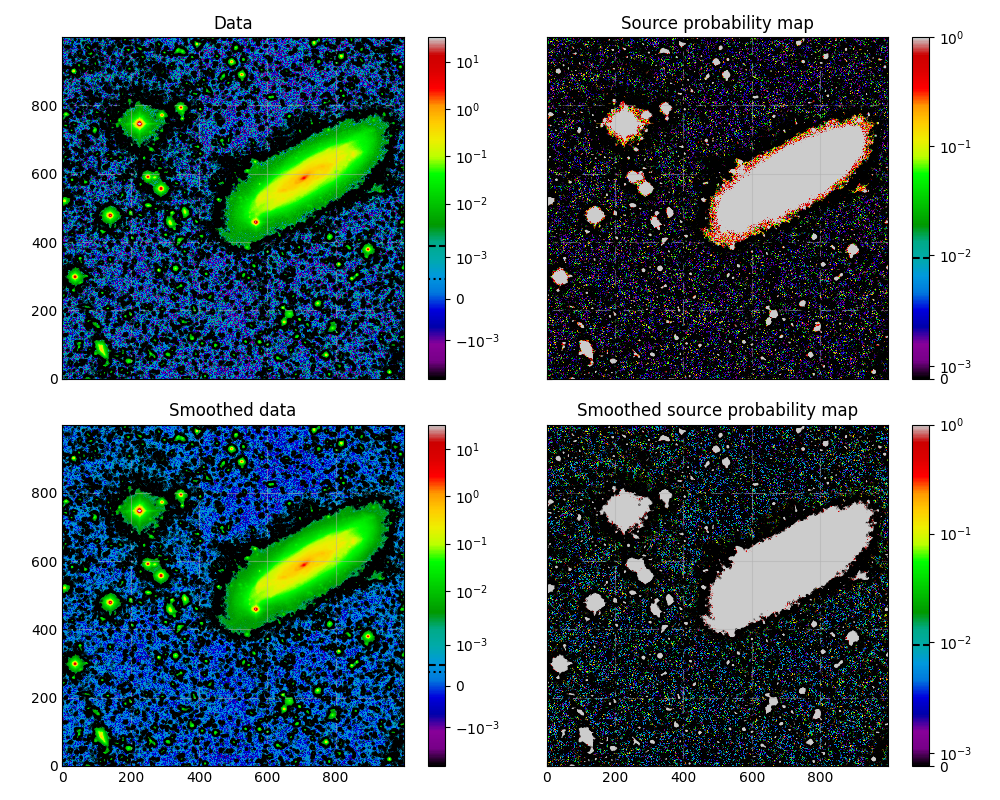

In [38]:
if plots and data_dimensionality == 2:
    plt.close('bg_map')
    fig = plt.figure('bg_map', figsize=(10, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Data')
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 0].contour(smoothed_data, levels=[threshold_guess], colors=['k'])
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(threshold_guess, c='k', ls='--')
    cb.ax.axhline(data_mode, c='k', ls=':')

    ax[0, 1].set_title('Source probability map')
    im = ax[0, 1].imshow(
        src_probability_map,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        norm = colors.SymLogNorm(vmin=0, linthresh=reliable_src_probability, vmax=1),
        )
    ax[0, 1].contour(smoothed_data, levels=[threshold_guess], colors=['k'])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(reliable_src_probability, c='k', ls='--')

    ax[1, 0].set_title('Smoothed data')
    im = ax[1, 0].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[1, 0].contour(smoothed_data, levels=[threshold_guess], colors=['k'])
    cb = fig.colorbar(im, ax=ax[1, 0])
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    cb.ax.axhline(smoothed_data_mode, c='k', ls=':')

    ax[1, 1].set_title('Smoothed source probability map')
    im = ax[1, 1].imshow(
        smoothed_src_probability_map,
        interpolation='nearest', origin='lower', cmap='nipy_spectral',
        norm = colors.SymLogNorm(vmin=0, linthresh=reliable_src_probability, vmax=1),
        )
    ax[1, 1].contour(smoothed_data, levels=[threshold_guess], colors=['k'])
    cb = fig.colorbar(im, ax=ax[1, 1])
    cb.ax.axhline(reliable_src_probability, c='k', ls='--')


## 7. Hierarchical Overdensity Tree (HOT)

### routine definition:

$$ S = \sum p_i (I_i - I_0) $$
$$ \sigma^2 = 2\sigma_0^2 \sum p_i $$

$$ n = \sum p_i $$
$$ \Delta S_n = p_n I_n + (n-1) I_{n-1} - n I_n = (p_n - 1) I_n + (n-1) (I_{n-1}-I_n) $$
$$ \Delta S_n > 0 ~~ \iff ~~ I_n < \frac{n-1}{1-p_n} I_{n-1} ~;~ 1-p_n < (n-1) \frac{I_{n-1}}{I_n} $$

$$ \Delta \sigma^2_i = p_i 2\sigma_0^2 $$

$$ \Delta \ln(S/N)^2 \sim \frac{(S+\Delta S)^2}{\sigma^2 + \Delta \sigma^2 } \frac{\sigma^2}{S^2} $$
$$ \propto \frac{S^2+p^2I^2+2pI}{1 + p } $$

$$
(S/N)^2_{a+b} = \frac{ (S_a + S_b)^2 }{ \sigma^2_a + \sigma^2_b }
= \frac{ \sigma^2_a\frac{S^2_a}{\sigma^2_a} + \sigma^2_b\frac{S^2_b}{\sigma^2_b}
        + 2 \sigma_a\sigma_b\frac{S_a}{\sigma_a}\frac{S_b}{\sigma_b} }{ \sigma^2_a + \sigma^2_b }
$$ 

In [39]:
@njit
def hot(data, smoothed_data, argsort_smoothed_data_ravel, threshold=-np.inf):
    """Hierarchical Overdenity Tree (HOT)"""

    strides = np.array(data.strides)//data.itemsize
    flat_data = data.ravel()
    flat_smoothed_data = smoothed_data.ravel()
    
    label = np.zeros(data.size, dtype=np.int32)
    n_labels = 0
    n_peaks_max = 1 + data.size//2**len(strides)  # maximum number of peaks
    parent = np.zeros(n_peaks_max, dtype=np.int32)
    area = np.zeros(n_peaks_max, dtype=np.int32)
    sum_value = np.zeros(n_peaks_max, dtype=data.dtype)
    max_signal_to_noise = np.zeros(n_peaks_max, dtype=np.float32)
    signal_to_noise_area = np.zeros(n_peaks_max, dtype=np.int32)

    for pixel in argsort_smoothed_data_ravel[::-1]:  # decreasing order
        pixel_value = flat_data[pixel]
        smoothed_pixel_value = flat_smoothed_data[pixel]
        if np.isnan(pixel_value):
            continue
        if smoothed_pixel_value < threshold:
            break

        neighbour_parents = []
        for stride in strides:
            if pixel >= stride:
                p = label[pixel-stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)
            if pixel+stride < data.size:
                p = label[pixel+stride]
                while p > 0:
                    pp = parent[p]
                    if pp == p:
                        break
                    else:
                        p = pp
                if p > 0 and p not in neighbour_parents:
                    neighbour_parents.append(p)

        neighbour_parents = np.array(neighbour_parents)
        n_parents = neighbour_parents.size
        if n_parents == 0:
            n_labels += 1
            selected_parent = n_labels
            parent[n_labels] = n_labels
        elif n_parents == 1:
            selected_parent = neighbour_parents[0]
        else:
            selected_parent = neighbour_parents[np.argmax(area[neighbour_parents])]
            for p in neighbour_parents:
                parent[p] = selected_parent

        label[pixel] = selected_parent
        area[selected_parent] += 1
        sum_value[selected_parent] += pixel_value
        n = area[selected_parent]
        signal_to_noise = (sum_value[selected_parent] - n*smoothed_pixel_value) / np.sqrt(n)
        if signal_to_noise > max_signal_to_noise[selected_parent]:
            max_signal_to_noise[selected_parent] = signal_to_noise
            signal_to_noise_area[selected_parent] = n
    
    n_src = np.count_nonzero(label)
    indep = np.where(parent[1:n_labels+1] == np.arange(1,n_labels+1))
    print(f'{n_labels} overdensities found:',
          f'{n_src} "pixels" ({int(100*n_src/data.size)}%),',
          f'{indep[0].size} independent regions',
         )
    area[0] = data.size-n_src
    catalog = (parent[:n_labels+1],
               area[:n_labels+1],
               max_signal_to_noise[:n_labels+1],
               signal_to_noise_area[:n_labels+1],
              )

    return label.reshape(data.shape), catalog


### selection based on inverted image:

In [40]:
#label_inv, catalog_inv = hot((data_mode-data)/bg_std, argsort_data_ravel[::-1], HOT_threshold)
label_inv, catalog_inv = hot(data_mode-data, data_mode-smoothed_data, argsort_smoothed_data_ravel[::-1], threshold_guess-data_mode)
parent_inv = catalog_inv[0]
area_inv = catalog_inv[1]
max_signal_to_noise_inv = catalog_inv[2]
signal_to_noise_area_inv = catalog_inv[3]


26667 overdensities found: 65258 "pixels" (6%), 19621 independent regions


Compute the upper hull of the inverted catalogue:

In [41]:
def upper_hull(x, y):
    """Compute upper hull"""
    
    points = np.array([x, y]).T
    hull = ConvexHull(points)
    i_max = np.argmax(x[hull.vertices])
    i_min = np.argmin(x[hull.vertices])
    if i_min > i_max:
        i = hull.vertices[i_max:i_min+1]
    else:
        i = np.concatenate([hull.vertices[i_max:], hull.vertices[:i_min+1]])
    srt = np.argsort(x[i])
    return x[i[srt]], y[i[srt]]


good_hull = (signal_to_noise_area_inv > 0)
log_area_inv = np.log(signal_to_noise_area_inv[good_hull])
signal = max_signal_to_noise_inv[good_hull]
signal_hull_x, signal_hull_y = upper_hull(log_area_inv, signal)

### analysis of the normal image:

In [42]:
#label, catalog = hot((data-data_mode)/bg_std, argsort_data_ravel, HOT_threshold)
label, catalog = hot(data, smoothed_data, argsort_smoothed_data_ravel, threshold_guess)
segmentation = segm.SegmentationImage(label)
parent = catalog[0]
area = catalog[1]
max_signal_to_noise = catalog[2]
signal_to_noise_area = catalog[3]


25686 overdensities found: 281046 "pixels" (28%), 10498 independent regions


In [43]:
hist_SN_inv, bins = np.histogram(max_signal_to_noise_inv, density=True, bins='auto')
hist_SN, bins = np.histogram(max_signal_to_noise, bins=bins, density=True)
bins_SN = (bins[1:]+bins[:-1])/2
SN_threshold = np.max(bins_SN[hist_SN_inv > .5*hist_SN])
print(f'Maximum signal-to-noise threshold = {SN_threshold:.3g}')


Maximum signal-to-noise threshold = 0.00366


In [59]:
true_overdensity = max_signal_to_noise > np.interp(np.log(signal_to_noise_area),
                                                   signal_hull_x, signal_hull_y, right=0)
true_overdensity |= max_signal_to_noise > SN_threshold
true_overdensity[0] = False
print(f'{np.count_nonzero(true_overdensity)} overdensities pass the selection criteria')

1353 overdensities pass the selection criteria


/tmp/ipykernel_290099/3142483216.py:1: RuntimeWarning: divide by zero encountered in log
  true_overdensity = max_signal_to_noise > np.interp(np.log(signal_to_noise_area),


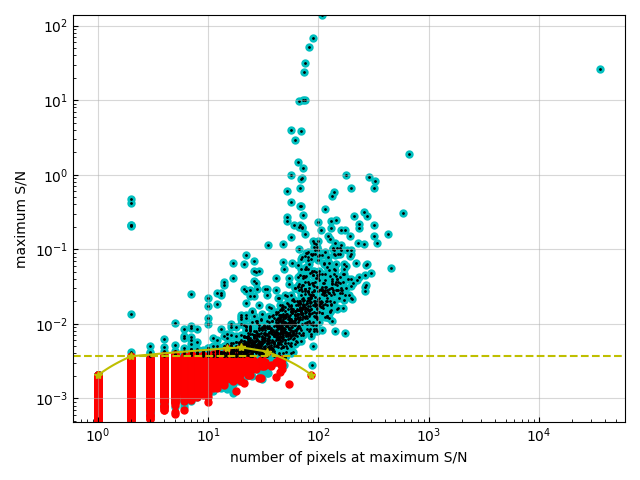

In [73]:
if plots:
    plt.close('catalogue_selection')
    fig = plt.figure('catalogue_selection')
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    '''
    #ax[1, 0].axhline(delta_th, c='k', ls=':')
    ax[1, 0].scatter(area[1:], max_value[1:]-min_value[1:], s=25, c='c')
    ax[1, 0].scatter(area[true_overdensity],
                     max_value[true_overdensity]-min_value[true_overdensity], s=1, c='k')
    ax[1, 0].plot(np.exp(contrast_hull_x), contrast_hull_y, 'y-*')
    ax[1, 0].scatter(area_inv[1:], max_value_inv[1:]-min_value_inv[1:], s=1, c='r')
    ax[1, 0].set_xscale('log')
    ax[1, 0].set_yscale('log')
    ax[1, 0].set_ylim(np.min(contrast_hull_y[contrast_hull_y > 0])/10)
    '''

    ax[0, 0].set_ylabel('maximum S/N')
    ax[0, 0].set_yscale('log')
    ax[0, 0].set_ylim(1e-1*np.max(signal_hull_y), np.max(max_signal_to_noise))
    ax[0, 0].scatter(signal_to_noise_area[1:], max_signal_to_noise[1:], s=25, c='c')
    ax[0, 0].scatter(signal_to_noise_area_inv[1:], max_signal_to_noise_inv[1:], s=25, c='r')
    ax[0, 0].scatter(signal_to_noise_area[true_overdensity], max_signal_to_noise[true_overdensity], s=1, c='k')
    #ax[0, 0].scatter(signal_to_noise_area_inv[good_hull], max_signal_to_noise_inv[good_hull], s=5, c='y')
    ax[0, 0].plot(np.exp(signal_hull_x), signal_hull_y, 'y*')
    xx = np.linspace(signal_hull_x[0], signal_hull_x[-1], 100)
    yy = np.interp(xx, signal_hull_x, signal_hull_y)
    ax[0, 0].plot(np.exp(xx), yy, 'y-')
    ax[0, 0].axhline(SN_threshold, color='y', ls='--')

    ax[-1, 0].set_xscale('log')
    ax[-1, 0].set_xlabel('number of pixels at maximum S/N')

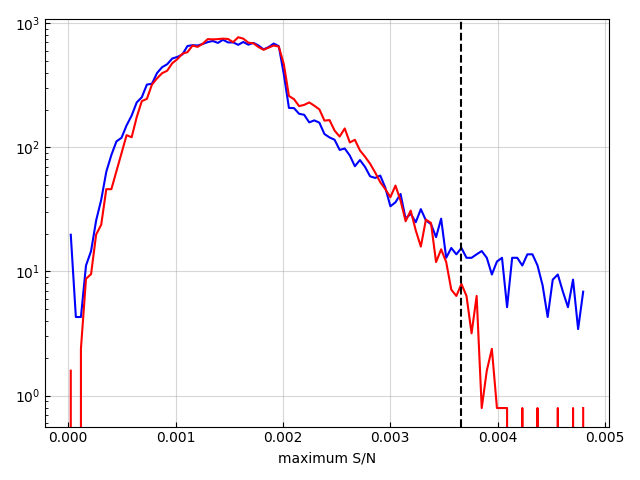

In [61]:
#sn_inv_sorted = np.sort(max_signal_to_noise_inv[1:])
#sn_sorted = np.sort(max_signal_to_noise[1:])

if plots:
    plt.close('SN_selection')
    fig = plt.figure('SN_selection')
    ax = fig.subplots(nrows=1, ncols=1, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_xlabel('maximum S/N')
    #ax[0, 0].set_xscale('log')
    ax[0, 0].set_yscale('log')
    #ax[0, 0].plot(sn_sorted, np.arange(sn_sorted.size), 'b-')
    #ax[0, 0].plot(sn_inv_sorted, np.arange(sn_inv_sorted.size), 'r-')
    ax[0, 0].plot(bins_SN, hist_SN, color='b')
    ax[0, 0].plot(bins_SN, hist_SN_inv, color='r')
    ax[0, 0].axvline(SN_threshold, color='k', ls='--')
    


## 8. Clean-up

### prune HOT based on selection threshold

In [62]:
original_labels = np.arange(parent.size)
island = (parent == original_labels)
pruned_labels = np.zeros_like(original_labels)
pruned_labels[true_overdensity | ~island] = original_labels[true_overdensity | ~island]

pruned_OK = true_overdensity[pruned_labels]
to_go = np.count_nonzero(~pruned_OK)
while True:
    print(f'{to_go} yet to go')
    pruned_labels[~pruned_OK] = parent[pruned_labels[~pruned_OK]]
    pruned_OK = true_overdensity[pruned_labels]
    still_to_go = np.count_nonzero(~pruned_OK)
    if still_to_go == to_go:
        break
    else:
        to_go = still_to_go
        #break

pruned_labels[~pruned_OK] = 0
pruned_segmentation = segm.SegmentationImage(pruned_labels[label])

24334 yet to go
14468 yet to go
12108 yet to go
11814 yet to go
11783 yet to go


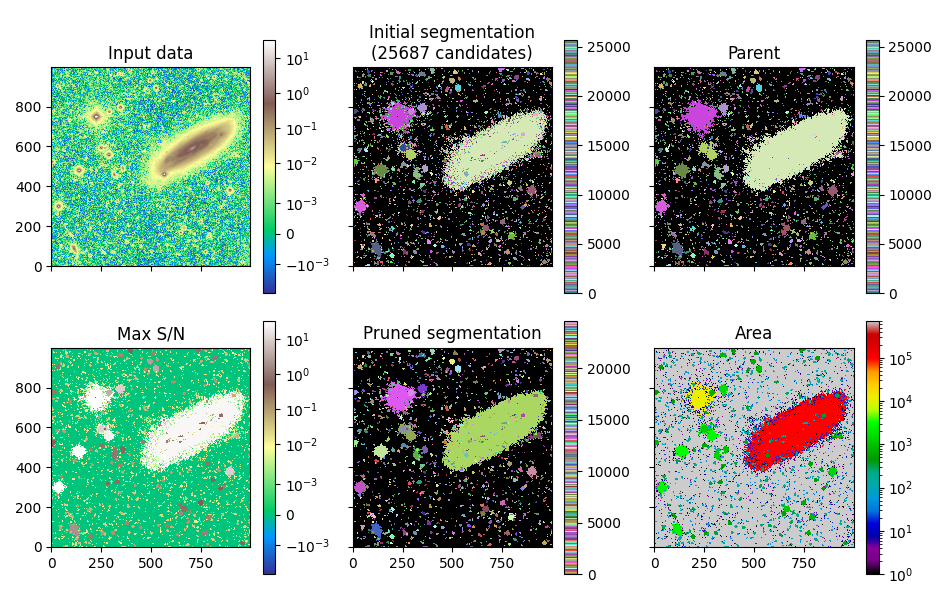

In [63]:
if plots and data_dimensionality == 2:
    plt.close('HOT')
    fig = plt.figure('HOT', figsize=(9.5, 6))
    fig.set_tight_layout(True)
    ax = fig.subplots(nrows=2, ncols=3, sharex=True, sharey=True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[0, 0])

    ax[0, 1].set_title(f'Initial segmentation\n({parent.size} candidates)')
    im = ax[0, 1].imshow(
        segmentation,
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 1])

    ax[0, 2].set_title('Parent')
    im = ax[0, 2].imshow(
        parent[label],
        interpolation='nearest', origin='lower', cmap=segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[0, 2])

    #ax[1, 0].set_title('Max value')
    #ax[1, 0].set_title('Contrast')
    ax[1, 0].set_title('Max S/N')
    im = ax[1, 0].imshow(
        #max_value[label]-min_value[label],
        max_signal_to_noise[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    '''
    ax[1, 1].set_title('S/N threshold')
    im = ax[1, 1].imshow(
        #saddle_value[label],
        signal_to_noise_threshold[label],
        interpolation='nearest', origin='lower', cmap='terrain', norm = colour_scale,
        )
    '''
    ax[1, 1].set_title('Pruned segmentation')
    im = ax[1, 1].imshow(
        pruned_segmentation,
        interpolation='nearest', origin='lower', cmap=pruned_segmentation.make_cmap(seed=123),
        )
    cb = fig.colorbar(im, ax=ax[1, 1])

    ax[1, 2].set_title('Area')
    im = ax[1, 2].imshow(
        area[label],
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm=colors.LogNorm(),
        )
    cb = fig.colorbar(im, ax=ax[1, 2])


### rename labels and create final catalogues

In [64]:
final_labels = pruned_labels.astype(np.int32)
old_label = np.sort(np.unique(pruned_labels))
new_label = np.zeros_like(parent)
n_final_labels = old_label.size
print(f'{n_final_labels} objects after mode filtering')

for i, lbl in enumerate(old_label):
    new_label[lbl] = i
    final_labels[final_labels == lbl] = i

new_parent = new_label[parent[old_label]]
final_labels = new_label[pruned_labels[label]]

1354 objects after mode filtering


In [65]:
#final_labels[data < signal_to_noise_threshold[label]] = 0

In [66]:
final_selection = segm.SegmentationImage(final_labels)
final_cmap = final_selection.make_cmap(seed=123)

In [67]:
if plots and data_dimensionality == 2:
    final_catalog = segm.SourceCatalog(data, final_selection)
    final_catalog.to_table()

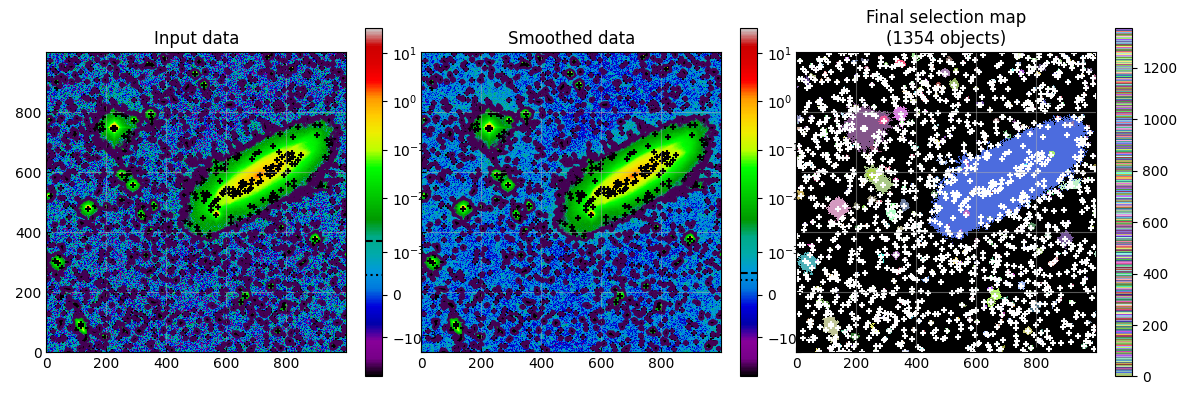

In [68]:
if plots and data_dimensionality == 2:
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(12, 4))
    ax = fig.subplots(nrows=1, ncols=3, squeeze=False,
                      sharex=True, sharey='row',
                      gridspec_kw={'hspace': 0, 'wspace': 0})
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data')
    im = ax[0, 0].imshow(
        data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 0].contour(final_labels, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(data_mode, c='k', ls=':')
    cb.ax.axhline(threshold_guess, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')
    ax[0, 0].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')

    ax[0, 1].set_title('Smoothed data')
    im = ax[0, 1].imshow(
        smoothed_data,
        interpolation='nearest', origin='lower', cmap='nipy_spectral', norm = colour_scale,
        )
    ax[0, 1].contour(final_labels, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(smoothed_data_mode, c='k', ls=':')
    cb.ax.axhline(smoothed_threshold_guess, c='k', ls='--')
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 0], color='k')
    ax[0, 1].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='k', marker='+')

    ax[0, 2].set_title(f'Final selection map\n({n_final_labels} objects)')
    im = ax[0, 2].imshow(
        final_selection,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    ax[0, 2].scatter(final_catalog.centroid[:, 0], final_catalog.centroid[:, 1], s=25, c='w', marker='+')
    cb = fig.colorbar(im, ax=ax[0, 2])
    #final_catalog.plot_kron_apertures(kron_params=(1, 1), axes=ax[0, 1], color='white')


In [69]:
if plots and data_dimensionality == 3:
    max_map = np.nanmax(final_labels, axis=0)
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(10, 10))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      #gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    fig.set_tight_layout(True)

    ax[0, 0].set_title('Normalised input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax((data-data_mode)/bg_std, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    ax[0, 0].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        np.sqrt(np.nanmean((data-data_mode)**2, axis=0)/bg_std**2),
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-data_mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        norm = colour_scale,
    )
    ax[0, 1].contour(max_map, levels=0)
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    cb.ax.axhline(threshold_guess-data_mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_final_labels} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower', cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])


In [70]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('filtered').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('filtered').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-data_mode)/bg_std
    section_lables = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = final_labels[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.nansum(section_labels**2, axis=2).T / (np.nansum(section_labels, axis=2).T + 1e-300)
    horizontal_slit = np.nansum(section_labels**2, axis=1).T / (np.nansum(section_labels, axis=1).T + 1e-300)

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap=final_cmap,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    for lbl in unique_section_labels:
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    ax[2, 0].axhline(delta_th*mean_error, c='k', ls=':')
    ax[2, 0].axhline(-delta_th*mean_error, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
                   interpolation='nearest', origin='lower', cmap='terrain', norm=colour_scale,
                  )
    ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        vmin=0, vmax=n_final_labels-1, cmap=final_cmap,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [71]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('HOT_labels.fits', overwrite=True)
hdu_out.header
'''
'''


'\n'

In [58]:
data_mode, smoothed_data_mode, threshold_guess, smoothed_threshold_guess

(0.00046682184457477564,
 0.00034289812813172285,
 0.001272232930232835,
 0.0005033853)